# 4 - Cas pràctic amb Datashader

Hi ha una varietat d'enfocaments per a representar gràficament grans conjunts de dades, però sovint la majoria d'ells no resulten satisfactoris.

Aquí mostram primer alguns dels problemes i després veim com empram la biblioteca datashader per a representar d'una manera pràctica i eficaç un gran conjunt de dades, en aquest cas un dataset amb més de 10 millons de registres.



## Instal·lació de Datashader en Google Colab

Ja hem vist que podem instal·lar Datashader amb PIP.

In [ ]:
!pip install datashader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 27.5 MB/s eta 0:00:00


## Càrrega de dades
Utilizarem un subconjunt de la base de dades de [viatges de taxis de Nueva York](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page), molt estudiada en nombrosos problemes i exemples de Big Data.

Aquest dataset conté les ubicacions i hores en les quals un passatger inicia i acaba el seu recorregut en taxi en la ciutat de Nova York durant el mes de gener de 2015.

In [ ]:
# Descarregam el dataset que està compartit en Google Drive
# La URL és https://drive.google.com/file/d/1tV1jkEjYiTLJueEEvLyd7Yl10RonOajY
# Per tant hem de fer-ho així:
!gdown 1tV1jkEjYiTLJueEEvLyd7Yl10RonOajY

Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1tV1jkEjYiTLJueEEvLyd7Yl10RonOajY

but Gdown can't. Please check connections and permissions.


In [ ]:
import pandas as pd
import numpy as np

usecols = ['dropoff_x','dropoff_y','pickup_x','pickup_y','dropoff_hour','pickup_hour','passenger_count']
df = pd.read_csv("nyc_taxi_processed.csv", usecols=usecols)
df.tail()

,passenger_count,pickup_x,pickup_y,dropoff_x,dropoff_y,pickup_hour,dropoff_hour
10679302,2,-8.232298e+06,4.980860e+06,-8.232492e+06,4.979234e+06,19,19
10679303,2,-8.235721e+06,4.972331e+06,-8.234857e+06,4.971131e+06,19,19
10679304,1,-8.235341e+06,4.975470e+06,-8.234203e+06,4.981092e+06,19,19
10679305,1,-8.237594e+06,4.973844e+06,-8.235618e+06,4.973722e+06,19,19
10679306,1,-8.233229e+06,4.977946e+06,-8.234152e+06,4.977120e+06,19,19


## Treballant directament amb Seaborn
Si representam els punts de destí del nostre dataframe (dropoff_x i dropoff_y) en Seaborn, veurem que tarda moltíssim en crear el gràfic. A més, hi ha tants punts que no podem observar res.

In [ ]:
import seaborn as sns

CPU times: user 7.01 s, sys: 1.33 s, total: 8.34 s
Wall time: 8.35 s


<Axes: xlabel='dropoff_x', ylabel='dropoff_y'>

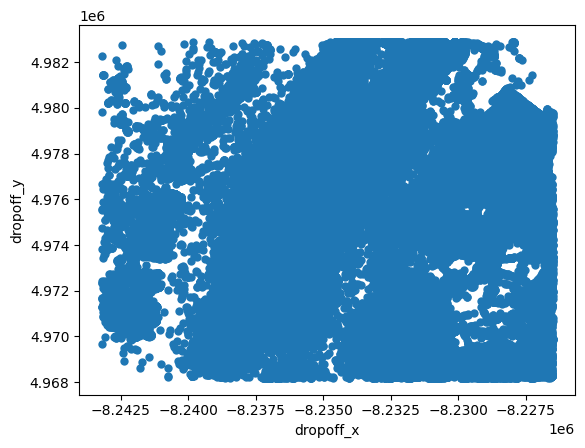

In [ ]:
%%time
sns.scatterplot(
    data=df,
    x="dropoff_x", y="dropoff_y", linewidth=0
)

Anam a provar de fer feina amb una mostra del 0,01% de les dades originals. Amb això sí que podem veure més o menys la forma de Manhattam, amb el forat de Central Park. Però hem perdut una quantitat enorme d'informació que pot ser rellevant (el 99,99% de les dades). I tampoc no tenim una idea d'on és que viatgen més passatgers: veim una zona molt saturada al sud de Central Park, però res mes.

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


<Axes: xlabel='dropoff_x', ylabel='dropoff_y'>

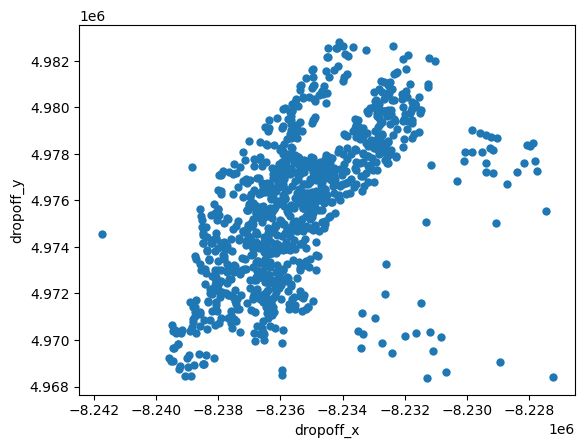

In [ ]:
%time
mostra = df.sample(frac=1e-4)
sns.scatterplot(
    data=mostra,
    x="dropoff_x", y="dropoff_y", linewidth=0
)

Podem provar de fer més petits els punts, però no canviarà gaire.

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


<Axes: xlabel='dropoff_x', ylabel='dropoff_y'>

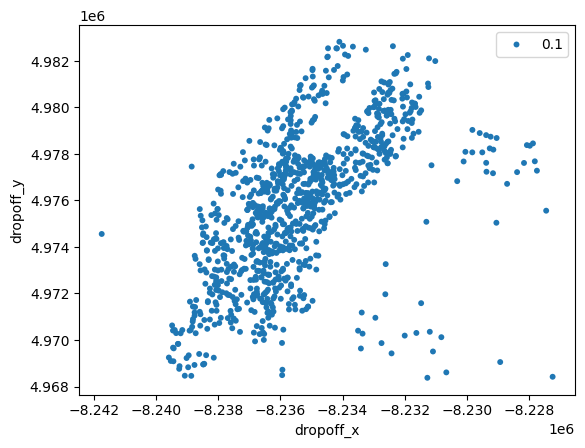

In [ ]:
%time
sns.scatterplot(
    data=mostra,
    x="dropoff_x", y="dropoff_y", size=0.1, linewidth=0
)

## Ús de Datashader
Para permitirnos trabajar con conjuntos de datos realmente grandes sin descartar la mayor parte de los datos, podemos adoptar un enfoque totalmente diferente. En lugar de utilizar un gráfico de dispersión Bokeh, que codifica cada punto en JSON y lo almacena en el archivo HTML que lee el navegador, podemos utilizar la biblioteca datashader para renderizar todo el conjunto de datos en un búfer de píxeles en un proceso Python separado, y luego proporcionar una imagen de tamaño fijo al navegador que contenga sólo los datos actualmente visibles. Este enfoque desvincula el procesamiento de datos de la visualización. El procesamiento de los datos sólo está limitado por la potencia de cálculo disponible, mientras que la visualización tiene restricciones mucho más estrictas determinadas por el dispositivo de visualización (un navegador web y su monitor particular, en este caso).

Como el número de puntos ya no es un factor limitante, ahora podemos utilizar todo el conjunto de datos (los más de 10 millones de viajes que tenemos en este dataset, aunque el usuario podría usar incluso los cerca de 150 millones de viajes que son públicos en la web del dataset). Y lo que es más importante, dado que el datashader permite el cálculo en las etapas intermedias del trazado, se pueden definir fácilmente operaciones como el auto-ranging (que está activado por defecto), de modo que podemos estar seguros de que no hay sobretrazado o saturación y no es necesario establecer parámetros como el alfa.

Los pasos implicados en el datashading son:
1.   Crear un objeto Canvas con la forma del trazado final (es decir, tener un grupo, bin en inglés, por cada píxel final que contendrá todos los puntos que caigan en este píxel).
2.   Agregar todos los puntos en ese conjunto de grupos (bins), contándolos de forma incremental.
3.   Mapear los recuentos resultantes en un color visible en un rango especificado para hacer una imagen.


In [ ]:
import datashader as ds
from datashader import transfer_functions as tf

In [ ]:
plot_width  = int(750)
plot_height = int(plot_width//1.2)
x_range, y_range =(-8242000,-8210000), (4965000,4990000)


In [ ]:
%%time
# 1. Crear objete Canvas
cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, x_range=x_range, y_range=y_range)
# 2. Funció d'agregació
agg = cvs.points(df, 'dropoff_x', 'dropoff_y',  ds.count('passenger_count'))
# 3. Mapejar els valors agregats a la imatge
img = tf.shade(agg, cmap=['white', 'darkblue'], how='linear')

CPU times: user 1.35 s, sys: 41.6 ms, total: 1.39 s
Wall time: 1.62 s


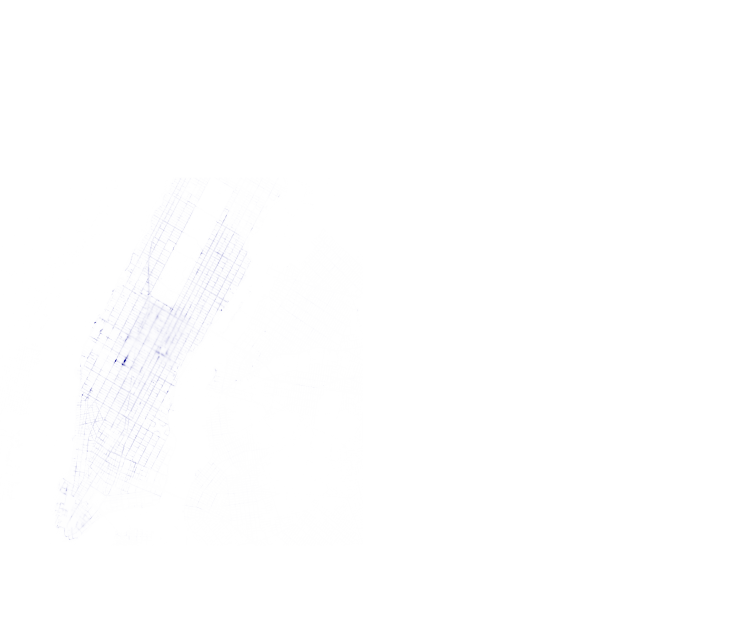

In [ ]:
img

Podem veure que la imatge s'ha generat en menys d'un segon, amb els 10.000.000 de punts.

La imatge obtinguda representa el recompte de viatgers en cada píxel, amb un color del rang especificat, que va del blanc al blau fosc. Aquest mapejat de colors s'ha fet de manera lineal, assumint que hi ha una distribució uniforme. El resultat ens permet intuir els carrers principals de Manhattan i veim alguns "punts calents" (que apareixen més foscos), que estan al voltant de Penn Station i el Madison Square Garden.

El problema és que quasi tota la imatge apareix en blanc i hi ha molt poc contrast, costa veure els carrers de Manhattan i la resta ni es veuen. Per què?

Perquè hem assumit que els valors del recompte per a cada punt (el número de viatges que hi acaben) segueixen una distribució uniforme, però no és així.

Vegem l'histograma.

<Axes: ylabel='Count'>

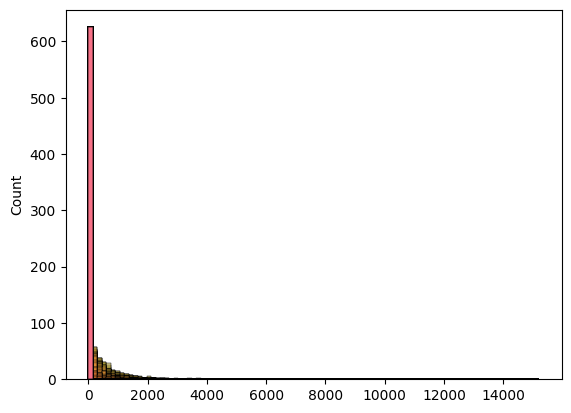

In [ ]:
sns.histplot(agg.values, bins=100, legend=False)

Sense fer gaire cas a les unitats del gràfic, està clar que les dades no es distribueixen uniformement, ja que la major part de píxels estan a prop del 0 i per tant queden amb color blanc o quasi blanc, que és imperceptible. La immensa majora dels píxels no estan donant una bona informació.

Per solucionar-ho, anam a utilitzar una distribució no lineal en el rang de colors. Per fer-ho, emprarem una transformació logarítimica, que ajudarà a revelar millor la realitat de les dades. Ho especificam mitjançant el paràmetre how, al qual li donam el valor 'log'.

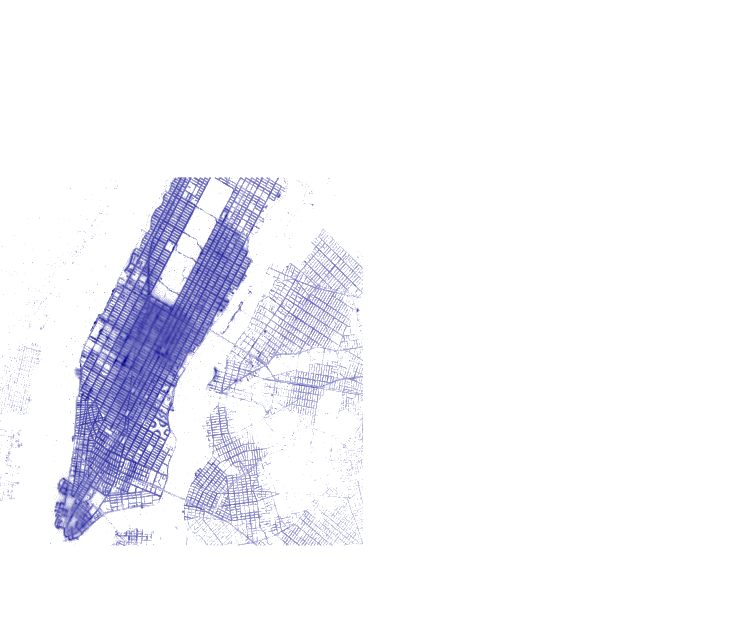

In [ ]:
tf.shade(agg, cmap=['white', 'darkblue'], how='log')

Ara ja sí podem veure perfectament la ciutat de Nova York! S'aprecien perfectament els carrers, ponts, parcs, etc. Les zones amb un blau més fosc són les que més vehicles han rebut.

No obstant això, l'elecció de la funció logarítimica és arbitrària. Per què aquesta i no altra? Està clar que aquesta funció aplana l'histograma i mostra millor la informació. Però és només una suposició (que ha funcionat bastant bé).

Però tenim la possitat de dir explícitament s'iguali (es faci pla), la qual cosa farà que sigui visible l'estructura de tots els nivells de dades (i, per tant, totes les ubicacions geogràfiques quedaran cobertes). Ho farem donant el valor 'eq_hist' al paràmetre how.

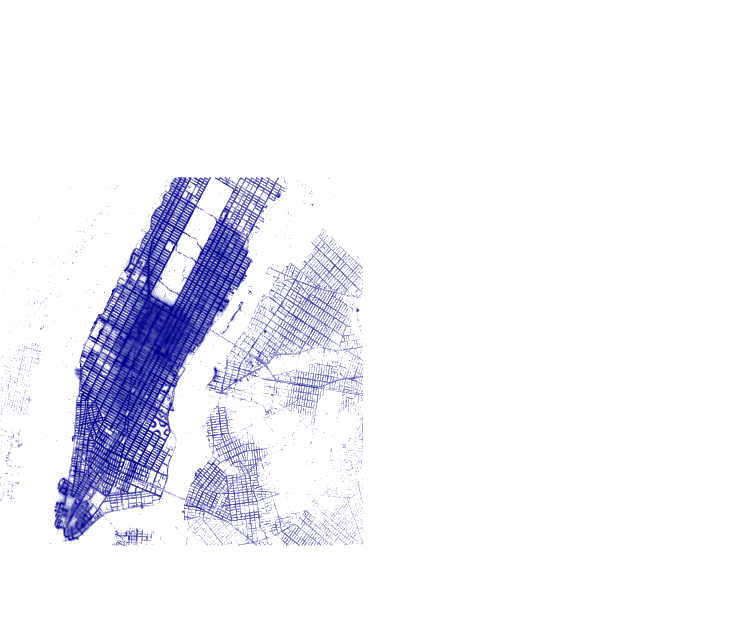

In [ ]:
tf.shade(agg, cmap=['white', 'darkblue'], how='eq_hist')

Ara es mostren millor totes les zones de la ciutat, i continuen quedant en color més fosc les zones amb més arribades.

Veurem millor els resultats si utilitzam una gamma de colors que vagi del blanc al vermell, passant entre mitges pel verd i el taronja.

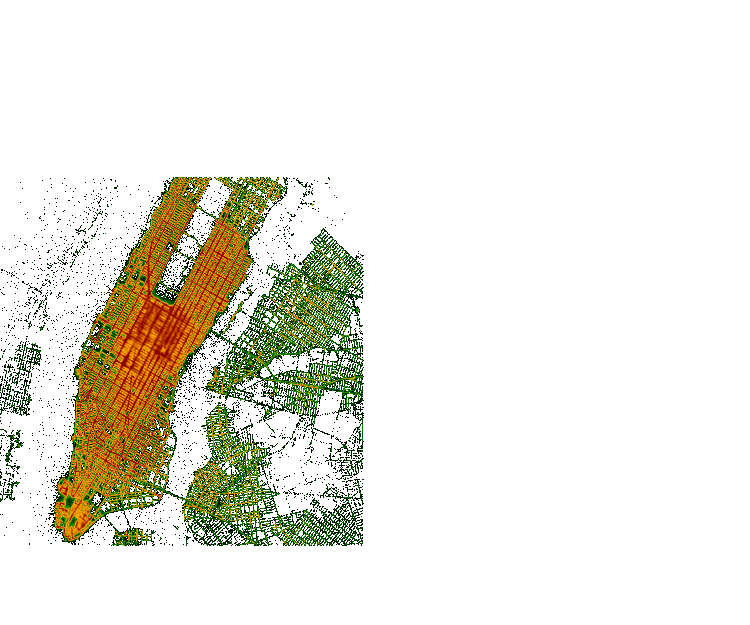

In [ ]:
tf.shade(agg, cmap=['white', 'green', 'orange', 'darkred'], how='eq_hist')


Ara es veu més clar que el sud de Central Park és la zona amb més densitat i també destaca l'extrem sud de l'illa de Manhattan.

Si ens fixam bé, també podem veure que hi ha alguns punts que cauen dins dels rius que envolten Manhattan. Com que les dades provenen dels GPS dels vehicles, en una zona amb edificis tan alts no és extrany que apareguin errors.


Una vegada hem acabat aquesta visualització, podria presentar-se als directius d'Uber a Nova York, o als responsables del trànsit a la ciutat perquè en puguin prendre decisions en base a aquesta informació.